In [418]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
from scipy.stats import uniform
warnings.filterwarnings('ignore')

In [478]:
df = pd.read_csv('https://drive.google.com/u/0/uc?id=1fABzTyH2tlMYjJyDOAnwkH0HkWAG27_L&export=download')
X, y = df.drop(columns='TARGET'), df['TARGET']
# train=0.8, test=0.1, validation=0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=555)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8888, random_state=555)

In [479]:
X

Id  bathrooms  bedrooms                       building_id  \
0       57094        1.0         3                                 0   
1       33389        1.0         1  9225efdfb57a50bf3ec17ebab082f94a   
2       60458        1.0         0  320de7d3cc88e50a7fbbcfde1e825d21   
3       53048        1.0         2  ce6d18bf3238e668b2bf23f4110b7b67   
4         592        1.0         3  fee4d465932160318364d9d48d272879   
...       ...        ...       ...                               ...   
34541   25582        1.0         1  14fdc4b01ae44b025f6c4d28c9097e5f   
34542   50013        1.0         0  9b6cf886379a2511f8c633c84028efe7   
34543  111475        2.0         2                                 0   
34544   71184        1.0         2  8754cae39f6e053974aa2337017eb3c1   
34545  117473        1.0         2  a068b783287190d47d1564ab4d898675   

                   created                                        description  \
0      2016-05-19 18:06:27  A FABULOUS 3BR IN MIDTOWN WEST!   PERFECT APAR...   
1      2016-06-16 02:01:49                    Renovated Kitchen and Bathroom!   
2      2016-05-04 02:42:50  RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...   
3      2016-05-12 05:57:56  Newly renovated flex 2 apartment offers the ne...   
4      2016-06-16 06:06:15  LOW FEE apartments do not come around like thi...   
...                    ...                                                ...   
34541  2016-06-16 02:12:57  Newly renovated bedroom apartment located off ...   
34542  2016-05-10 03:17:32  All apartments are newly renovated featuring: ...   
34543  2016-04-21 03:29:35  <![CDATA[2 bedrooms, 5110, Astoria / Long Isla...   
34544  2016-05-14 02:27:47  CooperCooper.com :: Listing ID #10_0385; 400 W...   
34545  2016-04-05 03:35:52  Renovated two bedroom apartment with beautiful...   

                                         display_address  \
0      HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...   
1                                   55 River Drive South   
2                                            W 77 Street   
3                                            John Street   
4                                       West 16th Street   
...                                                  ...   
34541                                            29th St   
34542                                           E 1st St   
34543                                        50th Avenue   
34544                               400 West 56th Street   
34545                                        E 82 Street   

                                                features  latitude  \
0              ['Laundry In Unit', 'No Fee', 'Elevator']   40.7647   
1             ['Dogs Allowed', 'Cats Allowed', 'No Fee']   40.7275   
2                        ['Elevator', 'Hardwood Floors']   40.7798   
3      ['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...   40.7081   
4      ['Laundry in Building', 'Laundry in Unit', 'Di...   40.7416   
...                                                  ...       ...   
34541                                        ['No pets']   40.7653   
34542  ['Pre-War', 'Laundry in Unit', 'Dishwasher', '...   40.7239   
34543                                                 []   40.7437   
34544  ['Laundry in Unit', 'Dishwasher', 'Cats Allowe...   40.7673   
34545                                                 []   40.7765   

       listing_id  longitude                        manager_id  \
0         7039994   -73.9918  4bdc3d8c1aaa90d997ce2cb77680679b   
1         7166774   -74.0322  e5808a5e6cc13988fe596704428d38d5   
2         6962716   -73.9751  d69d4e111612dd12ef864031c1148543   
3         7002458   -74.0065  e6472c7237327dd3903b3d6f6a94515a   
4         7170465   -74.0025  6fba9b3a8327c607b8b043716efee684   
...           ...        ...                               ...   
34541     7166867   -73.9248  e6472c7237327dd3903b3d6f6a94515a   
34542     6989251   -73.9901  5599e962719af3ccc2976855c2d5893c   
34543     6905568

Сначала сделаем предобработку данных из обучающей выборки, а затем проведем EDA

In [518]:
import uuid
import datetime
from sklearn.preprocessing import StandardScaler

class FeatureEngineering:
    def type_cast(self, X):
        return X.astype(dtype={'Id': int, 'bathrooms': float, 'building_id': 'string', 'created': 'string', 'description': 'string', 'display_address': 'string',
                'features': 'string', 'latitude': float, 'listing_id': int, 'longitude': float, 'manager_id': 'string', 'price': int, 'street_address': 'string'})
    
    def fit_transform(self, X: pd.DataFrame):
        self._feature_to_default_val = {'bathrooms': X['bathrooms'].mean(), 'bedrooms': X['bedrooms'].mean(), 'description': '', 'display_address': '', 
                                        'latitude': X['latitude'].mode()[0], 'longitude': X['longitude'].mode()[0], 'price': X['price'].mean(), 'street_address': ''}
        X = X.drop(columns='photos')
        X = self.type_cast(X)
        X = X.fillna(self._feature_to_default_val)
        X.loc[X['bathrooms'] <= 0]['bathrooms'] = self._feature_to_default_val['bathrooms']
        X.loc[X['bedrooms'] <= 0]['bedrooms'] = self._feature_to_default_val['bedrooms']
        X.loc[X['description'].apply(lambda s: s.isspace())]['description'] = self._feature_to_default_val['description']
        X.loc[X['display_address'].apply(lambda s: s.isspace()) ]['display_address'] = self._feature_to_default_val['display_address']
        X.loc[X['latitude'] == 0]['latitude'] = self._feature_to_default_val['latitude']
        X.loc[X['longitude'] == 0]['longitude'] = self._feature_to_default_val['longitude']
        X.loc[X['price'] == 0]['price'] = self._feature_to_default_val['price']
        X.loc[X['street_address'].apply(lambda s: s.isspace())]['street_address'] = self._feature_to_default_val['street_address']
        X.loc[X['building_id'] == '0', 'building_id'] = [uuid.uuid4().hex for x in X[X['building_id'] == '0']['building_id']]
        X['created'] = X['created'].apply(lambda created_at: int(datetime.datetime.strptime(created_at, '%Y-%m-%d %H:%M:%S').timestamp() / 3600))
        return X

    def transform(self, X: pd.DataFrame):
        X = X.drop(columns='photos')
        X = self.type_cast(X)
        X = X.fillna(self._feature_to_default_val)
        X.loc[X['bathrooms'] <= 0]['bathrooms'] = self._feature_to_default_val['bathrooms']
        X.loc[X['bedrooms'] <= 0]['bedrooms'] = self._feature_to_default_val['bedrooms']
        X.loc[X['description'].apply(lambda s: s.isspace())]['description'] = self._feature_to_default_val['description']
        X.loc[X['display_address'].apply(lambda s: s.isspace())]['display_address'] = self._feature_to_default_val['display_address']
        X.loc[X['latitude'] == 0]['latitude'] = self._feature_to_default_val['latitude']
        X.loc[X['longitude'] == 0]['longitude'] = self._feature_to_default_val['longitude']
        X.loc[X['price'] == 0]['price'] = self._feature_to_default_val['price']
        X.loc[X['street_address'].apply(lambda s: s.isspace())]['street_address'] = self._feature_to_default_val['street_address']
        X.loc[X['building_id'] == '0', 'building_id'] = [uuid.uuid4().hex for x in X[X['building_id'] == '0']['building_id']]
        X['created'] = X['created'].apply(lambda created_at: int(datetime.datetime.strptime(created_at, '%Y-%m-%d %H:%M:%S').timestamp() / 3600))
        return X
    
    def get_dummies(self, X: pd.DataFrame):
        feat_list = X['features'].apply(lambda s: [segment.strip() for segment in s.replace('"', '').replace('\'', '').replace('[', '').replace(']', '').split(',')])
        feat_dummies = feat_list.str.join('|').str.get_dummies()
        X = pd.get_dummies(data=X, columns=['building_id', 'description', 'display_address', 'manager_id', 'street_address'])
        return pd.concat([feat_dummies, X], axis=1).drop(columns='features')
    
    def fit_transform_y(self, y: pd.Series):
        return self.transform_y(y)
    
    def transform_y(self, y: pd.Series):
        return y.astype(str).map({'low': 1, 'medium': 2, 'high': 3})

In [481]:
feat_eng = FeatureEngineering()
X_train_proc = feat_eng.fit_transform(X_train)
X_val_proc = feat_eng.transform(X_val)
X_test_proc = feat_eng.transform(X_test)
X_concatted = pd.concat([X_train_proc, X_val_proc, X_test_proc], axis=0)

y_train_proc = feat_eng.fit_transform_y(y_train)
y_val_proc = feat_eng.transform_y(y_val)
y_test_proc = feat_eng.transform_y(y_test)

Id     bathrooms      bedrooms        created      latitude  \
count   34546.000000  34546.000000  34546.000000   34546.000000  34546.000000   
mean    61873.351618      1.211182      1.540815  406494.600619     40.741878   
std     35718.160364      0.496217      1.116735     620.900264      0.622257   
min         6.000000      0.000000      0.000000  405428.000000      0.000000   
25%     30839.250000      1.000000      1.000000  405938.000000     40.728000   
50%     61822.500000      1.000000      1.000000  406500.000000     40.751600   
75%     92705.500000      1.000000      2.000000  407051.000000     40.774000   
max    124009.000000      6.000000      8.000000  407560.000000     44.603800   

         listing_id     longitude         price  
count  3.454600e+04  34546.000000  3.454600e+04  
mean   7.024901e+06    -73.954803  3.888823e+03  
std    1.263556e+05      1.126953  2.630662e+04  
min    6.811965e+06    -75.521400  4.500000e+01  
25%    6.917211e+06    -73.991700  2.500000e+03  
50%    7.021834e+06    -73.977900  3.150000e+03  
75%    7.130020e+06    -73.954900  4.100000e+03  
max    7.742803e+06      0.000000  4.490000e+06

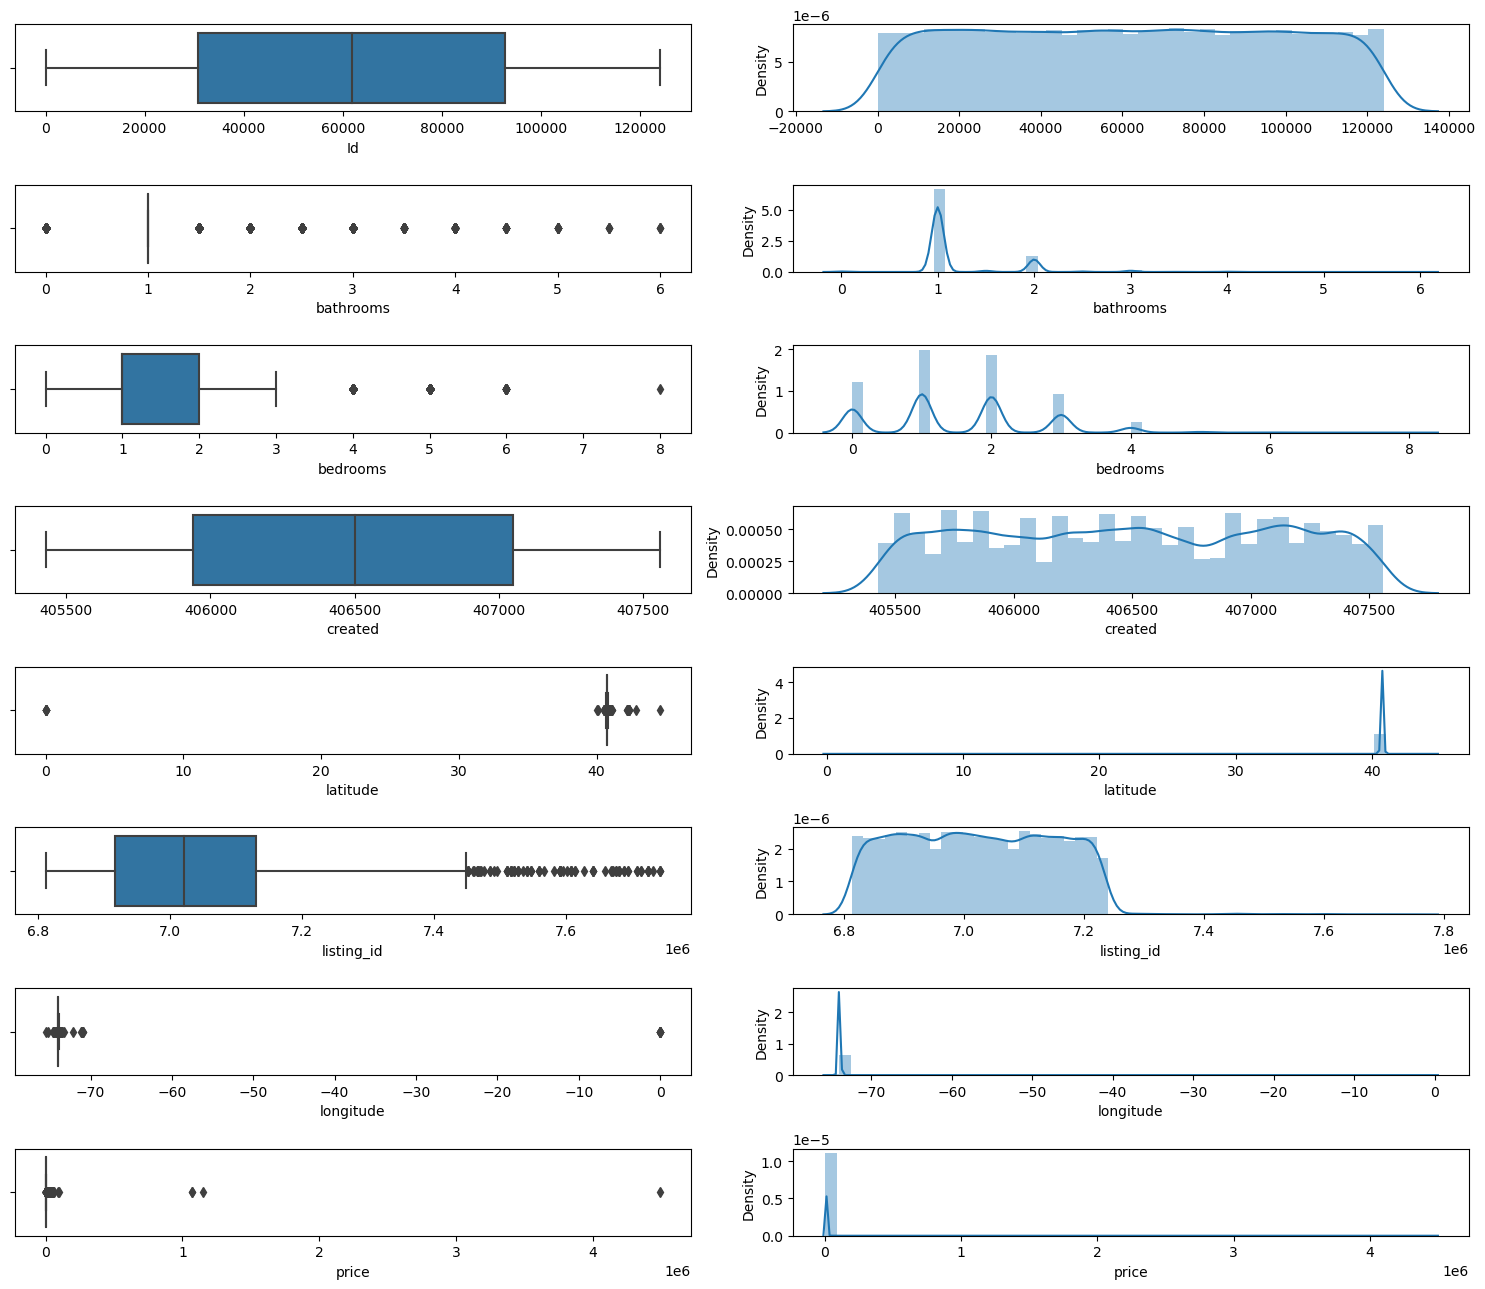

In [484]:
display(X_concatted.describe())

fig, ax = plt.subplots(8, 2, figsize = (15, 13))
sns.boxplot(x=X_concatted['Id'], ax = ax[0,0])
sns.distplot(x=X_concatted['Id'], ax = ax[0,1])
sns.boxplot(X_concatted['bathrooms'], ax = ax[1,0])
sns.distplot(X_concatted['bathrooms'], ax = ax[1,1])
sns.boxplot(X_concatted['bedrooms'], ax = ax[2,0])
sns.distplot(X_concatted['bedrooms'], ax = ax[2,1])
sns.boxplot(X_concatted['created'], ax = ax[3,0])
sns.distplot(X_concatted['created'], ax = ax[3,1])
sns.boxplot(X_concatted['latitude'], ax = ax[4,0])
sns.distplot(X_concatted['latitude'], ax = ax[4,1])
sns.boxplot(X_concatted['listing_id'], ax = ax[5,0])
sns.distplot(X_concatted['listing_id'], ax = ax[5,1])
sns.boxplot(X_concatted['longitude'], ax = ax[6,0])
sns.distplot(X_concatted['longitude'], ax = ax[6,1])
sns.boxplot(X_concatted['price'], ax = ax[7,0])
sns.distplot(X_concatted['price'], ax = ax[7,1])
plt.tight_layout()

In [485]:
X_concatted.apply(lambda col: col.duplicated()).sum()

Id                     0
bathrooms          34534
bedrooms           34538
building_id        22456
created            33002
description         6788
display_address    27547
features           26301
latitude           32364
listing_id             0
longitude          32980
manager_id         31412
price              32139
street_address     22147
dtype: int64

1. Убрать признаки `Id` и `listing_id` нельзя, хотя в них вообще нет повторяющихся значений. Без них модели очень плохие метрики показывают. 
2. Ненужные признаки уберем на этапе `SelectKBest` и `PCA`.

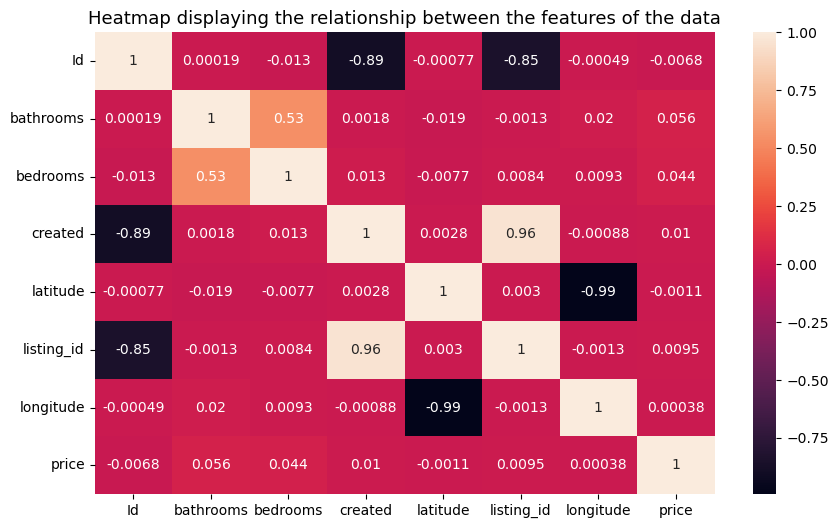

In [486]:
plt.figure(figsize=(10,6))
sns.heatmap(X_concatted.corr(),annot=True)
plt.title('Heatmap displaying the relationship between the features of the data',
         fontsize=13)
plt.show()

На матрице корреляции выше видно, что `Id`, `listing_id` и `created` имеют высокую корреляцию друг с другом, а `latitude` с `longitude`, но если все id заменить одним, а из `latitude` и `longitude` оставить только что-то одно, то модель будет показывать очень плохие метрики на valid датасете.

"low" target percentage: 69.46969258380132%
"medium" target percentage: 22.752272332542116%
"high" target percentage: 7.778035083656574%


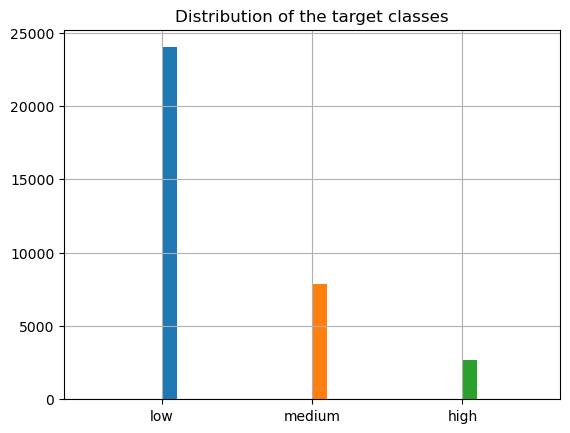

In [487]:
y[y == 'low'].hist()
y[y=='medium'].hist()
y[y=='high'].hist();
plt.title('Distribution of the target classes');
print('"low" target percentage: {0}%\n"medium" target percentage: {1}%\n"high" target percentage: {2}%'.format((y == 'low').sum() / y.size * 100,
 (y == 'medium').sum() / y.size * 100, (y == 'high').sum() / y.size * 100))

Оптимизировать будем macro avg для F1 score, тк классы не сбалансированы, а нам они одинаково важны. Кажется, что dummy классификатор, предсказывающий стратифицированное значение target, тут может быть хорошим соперником для сравнения. Также хочется, чтобы еще и weighted avg был выше, чем в dummy классификаторе с mode значением.

In [488]:
X_concatted = feat_eng.get_dummies(X_concatted)
X_train_proc = X_concatted.head(X_train_proc.shape[0])
X_val_proc = X_concatted.iloc[X_train_proc.shape[0]: X_train_proc.shape[0]+X_val_proc.shape[0]]
X_test_proc = X_concatted.tail(X_test_proc.shape[0])

std_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train_proc = pd.DataFrame(index=X_train_proc.index, columns=X_train_proc.columns, data=std_scaler.fit_transform(X_train_proc))
X_val_proc = pd.DataFrame(index=X_val_proc.index, columns=X_val_proc.columns, data=std_scaler.transform(X_val_proc))
X_test_proc = pd.DataFrame(index=X_test_proc.index, columns=X_test_proc.columns, data=std_scaler.transform(X_test_proc))

In [489]:
X_concatted.shape

(34546, 63633)

Уменьшим размерность сначала через SelectKBest примерно 10 раз, а затем еще раз через PCA на основании собственных значений векторов путем максимизации объясненной дисперсии на тренировочном датасете

In [490]:
feat_selection = SelectKBest(k=5000)
X_train_proc = feat_selection.fit_transform(X_train_proc, y_train_proc)
X_val_proc = feat_selection.transform(X_val_proc)
X_test_proc = feat_selection.transform(X_test_proc)

In [491]:
mean_vec = np.mean(X_train_proc, axis=0)
cov_mat = np.cov(X_train_proc.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp_float = np.array(cum_var_exp, dtype='f')
var_exp_float = np.array(var_exp, dtype='f')

In [492]:
from plotly import graph_objs as go
import plotly.subplots as tls

trace1 = go.Scatter(
    x=list(range(5000)),
    y= cum_var_exp_float,
    mode='lines+markers',
    name="'Cumulative Explained Variance'",
    line=dict(
        shape='spline',
        color = 'goldenrod'
    )
)
trace2 = go.Scatter(
    x=list(range(5000)),
    y= var_exp_float,
    mode='lines+markers',
    name="'Individual Explained Variance'",
    line=dict(
        shape='linear',
        color = 'black'
    )
)
fig = tls.make_subplots(insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.5}],
                          print_grid=True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2,1,1)
fig.layout.title = 'Explained Variance plots - Full and Zoomed-in'
fig.layout.xaxis = dict(range=[0, 5000], title = 'Feature columns')
fig.layout.yaxis = dict(range=[0, 5000], title = 'Explained Variance')
fig.show()

This is the format of your plot grid:
[ (1,1) x,y ]

With insets:
[ x2,y2 ] over [ (1,1) x,y ]



Кажется, 3000 признаков включает в себя ~100% объясненной дисперсии. Выберем их через PCA

In [493]:
pca = PCA(n_components=3000, svd_solver='auto')
X_train_proc_reduced = pca.fit_transform(X_train_proc)
X_val_proc_reduced = pca.transform(X_val_proc)
X_test_proc_reduced = pca.transform(X_test_proc)

Попробуем визуализировать через PCA топ 2 признака на плоскости

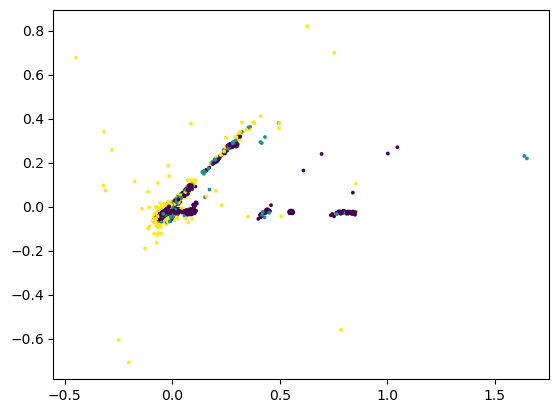

In [494]:
pca = PCA(n_components=2, svd_solver='auto')
X_train_visualization = pca.fit_transform(X_train_proc_reduced)
X_val_visualization = pca.transform(X_val_proc_reduced)
mask = np.array(X_train_visualization[:, 0] < 5) & np.array(X_train_visualization[:, 1] < 30)
X_train_vis = X_train_visualization[mask]
y_train_vis = y_train_proc[mask]
plt.scatter(X_train_vis[:, 0], X_train_vis[:, 1], c=y_train_vis, s=3)

Без ядер тут явно ничего линейно не разделить. Кажется, что лучше всех должен справиться SVM

Сделаем dummy предсказания, для того, чтобы был какой-то бейзлайн

In [390]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train_proc_reduced, y_train_proc)
y_dummy_pred = dummy.predict(X_val_proc_reduced)
print(classification_report(y_val_proc, y_dummy_pred))

              precision    recall  f1-score   support

           1       0.69      0.70      0.70      2374
           2       0.23      0.23      0.23       806
           3       0.08      0.08      0.08       278

    accuracy                           0.54      3458
   macro avg       0.33      0.33      0.33      3458
weighted avg       0.54      0.54      0.54      3458



In [399]:
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train_proc_reduced, y_train_proc)
y_dummy_pred = dummy.predict(X_val_proc_reduced)
print(classification_report(y_val_proc, y_dummy_pred))

              precision    recall  f1-score   support

           1       0.69      1.00      0.81      2374
           2       0.00      0.00      0.00       806
           3       0.00      0.00      0.00       278

    accuracy                           0.69      3458
   macro avg       0.23      0.33      0.27      3458
weighted avg       0.47      0.69      0.56      3458



И далее пойдем по моделям:

In [497]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, max_samples=.7, bootstrap=True, random_state=78, class_weight='balanced')
random_forest_classifier.fit(X_train_proc_reduced, y_train_proc)
y_pred = random_forest_classifier.predict(X_val_proc_reduced)

In [498]:
print(classification_report(y_val_proc, y_pred))

              precision    recall  f1-score   support

           1       0.74      0.93      0.83      2374
           2       0.45      0.24      0.31       806
           3       0.46      0.08      0.14       278

    accuracy                           0.70      3458
   macro avg       0.55      0.42      0.43      3458
weighted avg       0.65      0.70      0.65      3458



In [499]:
svm_classificator = SVC(class_weight='balanced')
svm_classificator.fit(X_train_proc_reduced, y_train_proc)
y_pred_svm = svm_classificator.predict(X_val_proc_reduced)

In [503]:
print(classification_report(y_val_proc, y_pred_svm))

              precision    recall  f1-score   support

           1       0.79      0.83      0.81      2374
           2       0.41      0.41      0.41       806
           3       0.29      0.16      0.21       278

    accuracy                           0.68      3458
   macro avg       0.50      0.47      0.48      3458
weighted avg       0.66      0.68      0.67      3458



In [495]:
log_reg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=78, multi_class='ovr')
log_reg.fit(X_train_proc_reduced, y_train_proc)
y_pred_log_reg = log_reg.predict(X_val_proc_reduced)

In [496]:
print(classification_report(y_val_proc, y_pred_log_reg))

              precision    recall  f1-score   support

           1       0.85      0.75      0.80      2374
           2       0.40      0.60      0.48       806
           3       0.32      0.17      0.22       278

    accuracy                           0.67      3458
   macro avg       0.52      0.51      0.50      3458
weighted avg       0.70      0.67      0.68      3458



In [395]:
estimators = [
     ('lr', LogisticRegression(penalty='l2', class_weight='balanced', random_state=78, multi_class='ovr')),
     ('rand_forest', RandomForestClassifier(random_state=78, class_weight='balanced', n_estimators=30, max_samples=.7, bootstrap=True))
]
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced', random_state=78), cv=5)
stacking_classifier.fit(X_train_proc_reduced, y_train_proc)
y_pred_stacking = stacking_classifier.predict(X_val_proc_reduced)

In [396]:
print(classification_report(y_val_proc, y_pred_stacking))

              precision    recall  f1-score   support

           1       0.88      0.68      0.76      2374
           2       0.37      0.70      0.49       806
           3       0.37      0.15      0.21       278

    accuracy                           0.64      3458
   macro avg       0.54      0.51      0.49      3458
weighted avg       0.72      0.64      0.66      3458



Сравним метрики с CatBoostClassifier:

In [405]:
from catboost import CatBoostClassifier

cb_classifier = CatBoostClassifier(verbose=False, random_state=78)
cb_classifier.fit(X_train_proc_reduced, y_train_proc)
predictions_catboost = cb_classifier.predict(X_val_proc_reduced)
print(classification_report(y_val_proc, predictions_catboost))

              precision    recall  f1-score   support

           1       0.79      0.87      0.83      2374
           2       0.44      0.45      0.45       806
           3       0.64      0.06      0.12       278

    accuracy                           0.71      3458
   macro avg       0.63      0.46      0.47      3458
weighted avg       0.70      0.71      0.68      3458



А теперь с Catboost без предобработки:

In [406]:
X_cb = X.drop(columns=['photos']).astype(dtype={'building_id':'str', 'created': 'str', 'description': 'str', 'display_address': 'str', 'street_address': 'str', 'features': 'str', 'manager_id': 'str'})
X_cb['created'] = X_concatted['created']
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y, train_size=0.8, random_state=555)
X_test_cb, _, y_test_cb, _ = train_test_split(X_test_cb, y_test_cb, train_size=0.5, random_state=555)
cb_classifier_raw = CatBoostClassifier(verbose=False, random_state=78)
cb_classifier_raw.fit(X_train_cb, y_train_cb, cat_features=['building_id', 'description', 'display_address', 'street_address', 'features', 'manager_id'])
predictions_catboost_raw = cb_classifier_raw.predict(X_test_cb)
print(classification_report(y_test_cb, predictions_catboost_raw))

              precision    recall  f1-score   support

        high       0.52      0.28      0.36       283
         low       0.81      0.92      0.86      2370
      medium       0.48      0.36      0.41       802

    accuracy                           0.74      3455
   macro avg       0.60      0.52      0.54      3455
weighted avg       0.71      0.74      0.71      3455



Так как мы максимизируем macro avg F1, то будем использовать логистическую регрессию, тк она имеет максимальный macro avg F1, ровно как и SVM. Однако SVM учится очень долго, потому тяжело будет подобрать для нее гиперпараметры.

In [453]:
params_to_opt = {'C': np.arange(0, 1, 0.1), 'class_weight': ['balanced', None], 'penalty': ['l1', 'l2', 'elasticnet', None]}
clf = RandomizedSearchCV(LogisticRegression(random_state=78, multi_class='ovr'), params_to_opt, random_state=78)
search = clf.fit(X_train_proc_reduced, y_train_proc)

In [454]:
search.best_params_

{'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.7000000000000001}

In [504]:
log_reg_tuned = LogisticRegression(penalty='l2', class_weight='balanced', random_state=78, multi_class='ovr', C=0.7)
log_reg_tuned.fit(X_train_proc_reduced, y_train_proc)
y_pred_log_reg_tuned = log_reg_tuned.predict(X_val_proc_reduced)
print(classification_report(y_val_proc, y_pred_log_reg_tuned))

              precision    recall  f1-score   support

           1       0.85      0.75      0.80      2374
           2       0.40      0.60      0.48       806
           3       0.32      0.16      0.21       278

    accuracy                           0.67      3458
   macro avg       0.52      0.50      0.50      3458
weighted avg       0.70      0.67      0.68      3458



Теперь попробуем предсказать test датасет:

In [505]:
log_reg_tuned = LogisticRegression(penalty='l2', class_weight='balanced', random_state=78, multi_class='ovr', C=0.7)
log_reg_tuned.fit(X_train_proc_reduced, y_train_proc)
y_pred_log_reg_tuned = log_reg_tuned.predict(X_test_proc_reduced)
print(classification_report(y_test_proc, y_pred_log_reg_tuned))

              precision    recall  f1-score   support

           1       0.84      0.75      0.79      2363
           2       0.40      0.59      0.47       826
           3       0.29      0.14      0.18       266

    accuracy                           0.66      3455
   macro avg       0.51      0.49      0.48      3455
weighted avg       0.69      0.66      0.67      3455



Проанализируем ошибки:

In [535]:
pred_errors_X = X_test[y_test_proc!=y_pred_log_reg_tuned]
pred_errors_y = y_test[y_test_proc!=y_pred_log_reg_tuned]

pred_errors_X = feat_eng_error_analysis.fit_transform(pred_errors_X)
pred_errors_y = feat_eng_error_analysis.fit_transform_y(pred_errors_y)
pred_errors_concat = pd.concat([pred_errors_X, pred_errors_y], axis=1)
pred_errors_concat.sample(15)

Id  bathrooms  bedrooms                       building_id  created  \
21031   91235        2.0         4  7bb43faedaa98b0a6d1e8b1195515551   405723   
8483    28040        1.0         0  de8e5029727a93d03c1ee943055b5005   407545   
6129    61234        1.0         2  1baadc9bc38b3ccaaf9704e7442f2672   406512   
15589   84976        1.0         1  f5732dc4e1296f82183001922151421e   405724   
15483  114051        1.0         0  b092133cc41ef8c65895dc16b95b64e4   405939   
21468   38210        1.0         1  699c1948d89ebd2249582a9d9a2b5c1a   406898   
6000    44734        1.0         3  94bfeda552bf428b9347ca2146028b42   406696   
7505    78776        1.0         2  a01c99eb2cfdde327e1691e17d6696ba   406419   
20618   72065        2.0         2  8b011d67e60a8c802192a1d7816dea85   406515   
11300  100876        1.0         2  2187166536514bc6a8955ada5b855105   405719   
5162    68194        1.0         3  51b34cd054435b45b6412339bac0a484   406609   
32010   22626        1.5         4  49d7e0dc12a21742bf6da72a9359601d   407400   
6894   107423        2.0         2  8883f68d1dbad4d5aa32c70cb277714d   405533   
14531   56925        1.0         2  9805e7c1cf13f3b18a63e61aec7ba577   406588   
14395   12015        1.0         2  c57570f985084585e8cc832c2d125b6e   407044   

                                             description  \
21031  ENORMOUS APARTMENT, CONVERTIBLE 4 BEDROOM WITH...   
8483   Call or Text Hakim to see this or ANYTHING in ...   
6129   PRIME LOCATION IN MURRAY HILL THIS BUILDING FE...   
15589  ** No Fee ** Renovated 3BR/2BA with Huge Priva...   
15483  *LAUNDRY***EAT-IN KITCHEN***MASSIVE RENOVATED ...   
21468  Queen sized BDRM, updated open kitchen,  Clean...   
6000   NO FEE Gut Renovated 3 Bedroom w/ Washer & Dry...   
7505   AMAZING and SPACIOUS 2 bedroom convertible. BE...   
20618  Come see this large two-bedroom two-bathroom i...   
11300  Building Description: Voice Intercom; Walk-Up;...   
5162   PERFECT FOR FAMILIES OR SHARES. Oversized Real...   
32010  Actual apartment photos<br /><br />Bond New Yo...   
6894   ______________________________________________...   
14531  STUNNING FLEX 2 BEDROOM APARTMENT LOCATED ON T...   
14395  Modern renovations throughout, with flowing sp...   

                                         display_address  \
21031                                   East 46th Street   
8483                                          7th Avenue   
6129                                            E 35 St.   
15589                                      Thompkins Ave   
15483                                    328 E 93 Street   
21468                                        E 76 Street   
6000                                   Chelsea 3 Bedroom   
7505                                    East 29th Street   
20618                                   West 24th Street   
11300                                       Grand Avenue   
5162                                    Lexington Avenue   
32010                                           Broadway   
6894                                           W 48th St   
14531                                          E 91st St   
14395  Beautiful Spacious Renovated Modern Kitchen & ...   

                                                features  latitude  \
21031  ['Roof Deck', 'Dining Room', 'Doorman', 'Eleva...   40.7516   
8483   ['prewar', 'Dogs Allowed', 'Cats Allowed', 'LO...   40.8136   
6129   ['Roof Deck', 'Balcony', 'Doorman', 'Elevator'...   40.7467   
15589  ['Terrace', 'Laundry in Unit', 'Dishwasher', '...   40.6877   
15483         ['Laundry in Building', 'Hardwood Floors']   40.7815   
21468                ['Hardwood Floors', 'Cats Allowed']   40.7694   
6000   ['Laundry In Unit', 'Cats Allowed', 'Dogs Allo...   40.7393   
7505   ['Balcony', 'Doorman', 'Elevator', 'Garden/Pat...   40.7412   
20618  ['Roof Deck', 'Doorman', 'Elevator', 'Fitness ...   40.7445   
11300                                        ['Pre-War']   40.8600   
5162   ['Cats Allowed'

Здесь слева будет распределение признака в оригинальном датасете, а справа - в тестовом датасете, где `TARGET` был предсказан с ошибками

Верхняя таблица - статистики тестового датасета. Нижняя - статистики датасета, на котором мы ошиблись

Id    bathrooms     bedrooms        created     latitude  \
count    3455.000000  3455.000000  3455.000000    3455.000000  3455.000000   
mean    61701.289436     1.206368     1.548770  406497.501881    40.739576   
std     35847.933905     0.474711     1.117002     629.445116     0.694989   
min        23.000000     0.000000     0.000000  405431.000000     0.000000   
25%     29982.000000     1.000000     1.000000  405935.000000    40.728300   
50%     61196.000000     1.000000     2.000000  406512.000000    40.752800   
75%     92589.000000     1.000000     2.000000  407064.000000    40.774050   
max    123996.000000     5.000000     6.000000  407559.000000    42.345900   

         listing_id    longitude         price       TARGET  
count  3.455000e+03  3455.000000  3.455000e+03  3455.000000  
mean   7.025448e+06   -73.950206  4.945467e+03     1.393054  
std    1.277409e+05     1.259817  7.635908e+04     0.626623  
min    6.812103e+06   -74.243200  4.500000e+01     1.000000  
25%    6.916165e+06   -73.991400  2.500000e+03     1.000000  
50%    7.023946e+06   -73.977800  3.163000e+03     1.000000  
75%    7.131366e+06   -73.954500  4.132000e+03     2.000000  
max    7.659212e+06     0.000000  4.490000e+06     3.000000

Id    bathrooms     bedrooms        created     latitude  \
count    1165.000000  1165.000000  1165.000000    1165.000000  1165.000000   
mean    62721.941631     1.166524     1.684120  406478.814592    40.749615   
std     36191.977587     0.382381     1.137368     628.807093     0.044170   
min        46.000000     0.000000     0.000000  405432.000000    40.506500   
25%     31393.000000     1.000000     1.000000  405915.000000    40.725500   
50%     61605.000000     1.000000     2.000000  406443.000000    40.751400   
75%     94187.000000     1.000000     2.000000  407043.000000    40.773900   
max    123995.000000     3.000000     6.000000  407548.000000    40.885500   

         listing_id    longitude         price       TARGET  
count  1.165000e+03  1165.000000   1165.000000  1165.000000  
mean   7.019547e+06   -73.969839   3165.958798     1.687554  
std    1.243860e+05     0.034051   1229.933949     0.781151  
min    6.813115e+06   -74.243200     45.000000     1.000000  
25%    6.913300e+06   -73.991300   2350.000000     1.000000  
50%    7.013663e+06   -73.976000   2950.000000     1.000000  
75%    7.126764e+06   -73.951200   3695.000000     2.000000  
max    7.475973e+06   -73.805800  10000.000000     3.000000

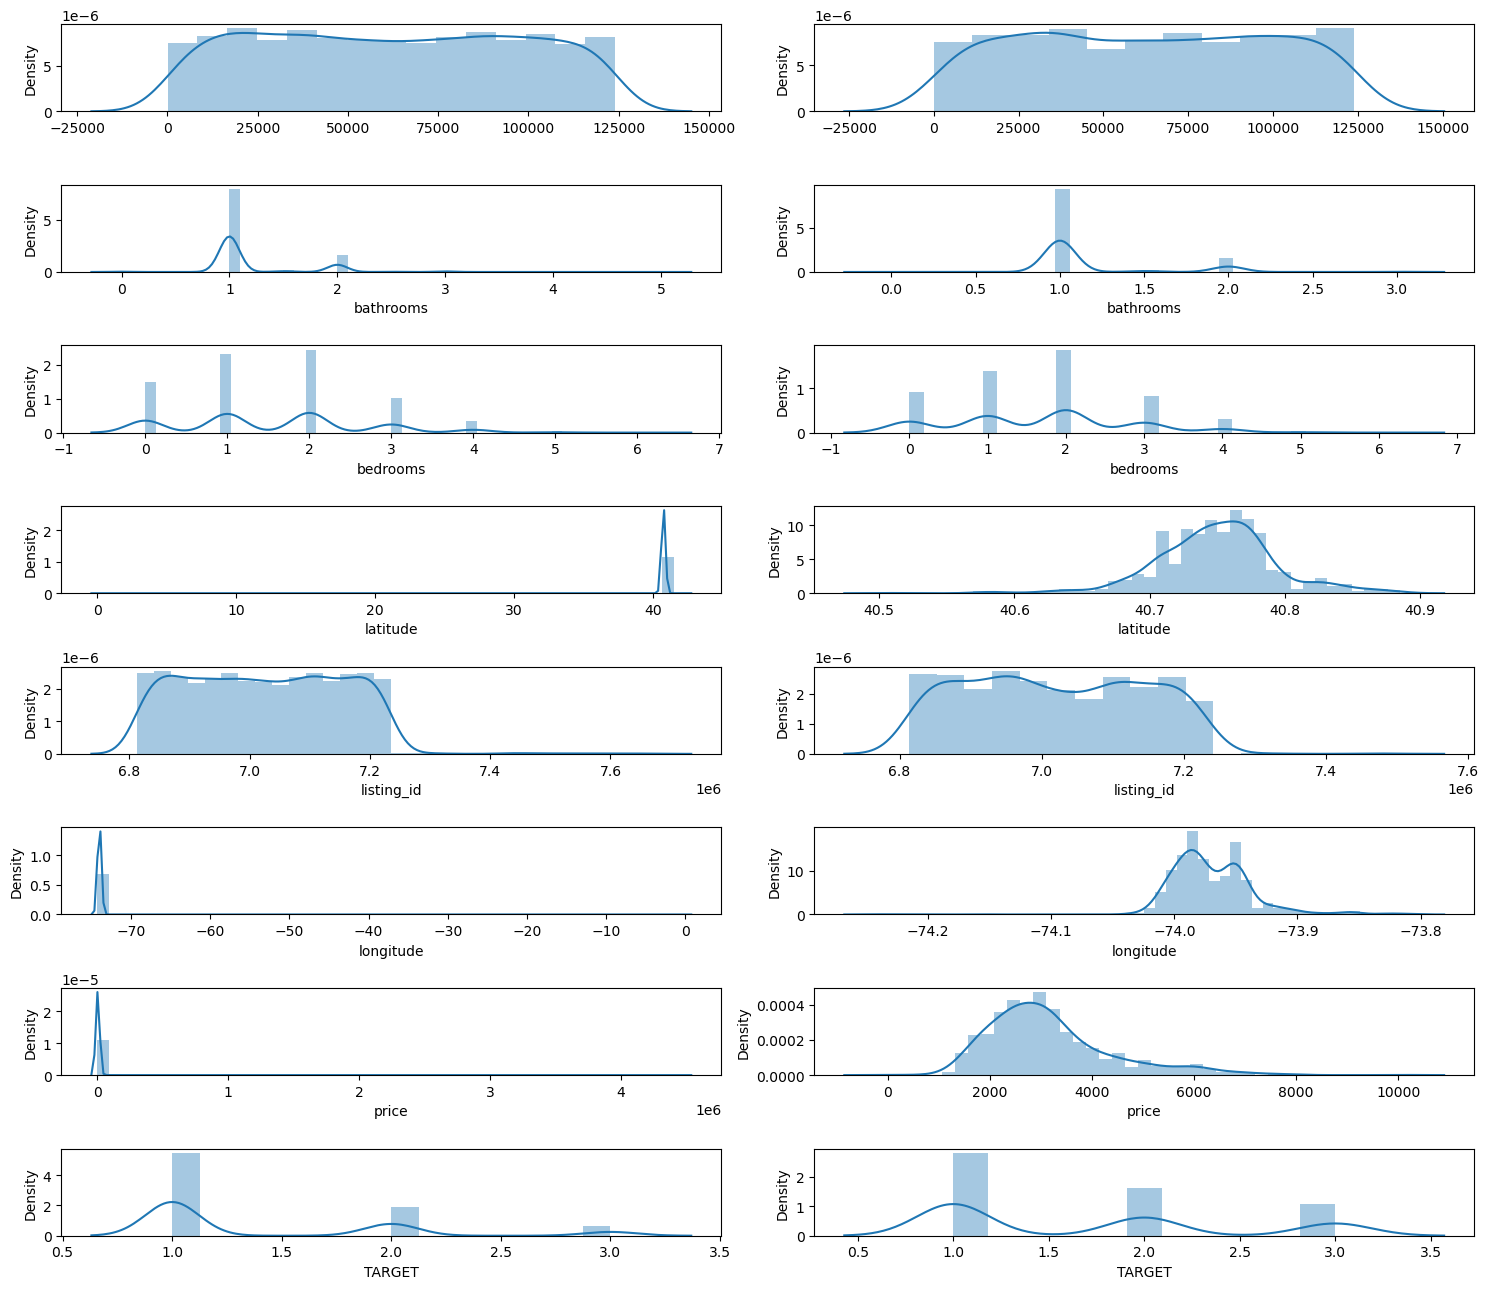

In [539]:
feat_eng_test = FeatureEngineering()
X_test_casted = feat_eng_test.fit_transform(X_test)
y_test_casted = feat_eng_test.fit_transform_y(y_test)
test_casted = pd.concat([X_test_casted, y_test_casted], axis=1)
display(test_casted.describe())
display(pred_errors_concat.describe())

fig, ax = plt.subplots(8, 2, figsize = (15, 13))
sns.distplot(x=test_casted['Id'], ax = ax[0,0])
sns.distplot(x=pred_errors_concat['Id'], ax = ax[0,1])
sns.distplot(test_casted['bathrooms'], ax = ax[1,0])
sns.distplot(pred_errors_concat['bathrooms'], ax = ax[1,1])
sns.distplot(test_casted['bedrooms'], ax = ax[2,0])
sns.distplot(pred_errors_concat['bedrooms'], ax = ax[2,1])
sns.distplot(test_casted['latitude'], ax = ax[3,0])
sns.distplot(pred_errors_concat['latitude'], ax = ax[3,1])
sns.distplot(test_casted['listing_id'], ax = ax[4,0])
sns.distplot(pred_errors_concat['listing_id'], ax = ax[4,1])
sns.distplot(test_casted['longitude'], ax = ax[5,0])
sns.distplot(pred_errors_concat['longitude'], ax = ax[5,1])
sns.distplot(test_casted['price'], ax = ax[6,0])
sns.distplot(pred_errors_concat['price'], ax = ax[6,1])
sns.distplot(y_test_casted, ax = ax[7,0])
sns.distplot(pred_errors_concat['TARGET'], ax = ax[7,1])
plt.tight_layout()

Мои выводы по ошибкам следующие: кажется, что нет какой-то закономерности в тестовых данных, которые мы предсказали неправильно. Выбросы были предсказаны верно, потому непрерывные независимые переменные стали иметь распределение, близкое к нормальному и std значительно уменьшился на таких признаках (`price`, `latitude`, `longitude`).